# 텐서플로를 이용한 가위바위보 분류기 만들기 

텐서플로의 Sequential API를 이용하여 쉽게 가위바위보 분류기 만들기 


### 데이터 만들기 

카메라만 연결되어있다면 구글 teachable machine에서 쉽게 이미지 데이터를 만들수있다.
가위, 바위, 보 각각 촬영하고 본인이 원하는 경로에 따로따로 폴더를 만들어 저장하자. 
[링크 ](https://teachablemachine.withgoogle.com/)

찍을 때 고려하면 좋은점들(과 그러면 해결할수있는 문제들)

1. 되도록 여러 각도에서 찍는게 좋음(Viewpoint Variation) 
2. 여러 크기로 찍는 것이 좋음(Deformation)
3. 여러 사람의 손을 찍는 것이 좋음(inttraclass Variation)
4. 여러 밝기로 촬영해보는것도 좋음(illumination changes)
5. 다른 배경을 바탕으로 찍어보는 것도 좋음(Background clutter)

필자는 가위 바위 보 각각 1000개의 이미지를 동료들과 함께 만들었다.  


### 데이터 전처리

#### 이미지 사이즈 변경
사진들을 열심히 찍고 다운로드를 마친다면 이미지 파일들이 224x224 pixel인것을 확인할 수있다. 이것으로 분석해도 괜찮지만 우리들의 컴퓨터 파워는 그렇게 좋지않을테니 이미지 파일을 28x28 단위로 resize 하기로 하자. 

In [2]:
# PIL library가 설치되어있지 않은 분은 설치
#!pip install pillow 
from PIL import Image
import glob
import numpy as np


# 각자 자기 파일 폴더로 
image_dir_path = "/home/ssac4/aiffel/report/rock_scissor_paper/train"

# 가위 폴더 
images=glob.glob(image_dir_path + "/scissor/*.jpg")  

# 가위 폴더의 이미지 파일 모두 28x28 사이즈로 바꾸어 저장. 
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")

print("보 이미지 resize 완료!")


보 이미지 resize 완료!


In [3]:

# 바위 폴더 경로 
images=glob.glob(image_dir_path + "/rock/*.jpg")  

# 바위 폴더 이미지 파일 모두 28x28 사이즈로 바꾸어 저장. 
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")




In [4]:
# 보 폴더 
images=glob.glob(image_dir_path + "/paper/*.jpg")  

# 보 폴더 이미지 파일 모두 28x28 사이즈로 바꾸어 저장. 
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")



#### 데이터 라벨링
우리가 가진 데이터에는 아직 이미지 데이터가 가위인지 바위인지 보인지에 대한 라벨링이 되어있지않다. 가위바위보는 3가지 경우이기때문에 가위는 0, 바위는 1, 보는 2라는 정보를 추가해서 라벨링해야한다.

아래 함수를 통해서 불러오고 라벨링하자 . 

In [5]:
# img_path는 파일경로. 아까 입력한 경로 그대로 쓰면된다. 
# number_of_data는 입력할 train 데이터를 적으면된다. 필자는 3000이다(3*1000)
def load_data(img_path,number_of_data):
    # 가위 : 0, 바위 : 1, 보 : 2
    # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels




image_dir_path = "/home/ssac4/aiffel/report/rock_scissor_paper/train"
(x_train, y_train)=load_data(image_dir_path,3000)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3000 입니다.
x_train shape: (3000, 28, 28, 3)
y_train shape: (3000,)


라벨:  0 가위


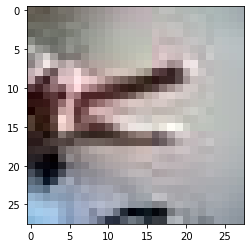

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

def ex_label(a):
    if a == 0:
        return "가위"
    elif a == 1:
        return "바위"
    else:
        return "보" 



print('라벨: ', y_train[0] , ex_label(y_train[0]))

28x28 픽셀의 이미지다 보니 상상이상으로 나쁘다.      
우린 참 훌륭한 세상에 살고 있었던 것이다.

### 딥러닝 네트워크 설계 

In [58]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
random.seed(a= 100)



model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
print('Model에 추가된 Layer 개수: ', len(model.layers))
model.summary()


Model에 추가된 Layer 개수:  7
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_51 (Dense)             

### 딥러닝 네트워크 학습 


In [59]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)


Epoch 1/10
94/94 [==============================] - 0s 1ms/step - loss: 2.4281 - accuracy: 0.4270
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 0.9093 - accuracy: 0.5760
Epoch 3/10
94/94 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.7063
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 0.5003 - accuracy: 0.7980
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.8493
Epoch 6/10
94/94 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.8840
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.9020
Epoch 8/10
94/94 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9293
Epoch 9/10
94/94 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9433
Epoch 10/10
94/94 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9577


### 테스트 데이터 입력하기 
테스트 데이터는 모델 학습에 사용되지 않은 데이터를 사용해야한다.     
그러므로 다시 아래 링크에서 이미지 데이터를 만든후 test 데이터를 놓아 따로 정리하자
필자는 가위 바위 보 각각 100개씩 총 300개의 test 데이터를 만들었다. 
[링크 ](https://teachablemachine.withgoogle.com/)

train 데이터와 같이 로드한 데이터를 정규화하도록 한다. 

In [60]:
# 각자 test data를 모은 링크를 사용하자 
image_dir_path = "/home/ssac4/aiffel/report/rock_scissor_paper/test"

(x_test, y_test)=load_data(image_dir_path,300)


print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))


학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


### 테스트 데이터로 모델 성능 확인해보기 

In [61]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))



10/10 - 0s - loss: 3.3978 - accuracy: 0.4567
test_loss: 3.397765636444092 
test_accuracy: 0.4566666781902313


필자의 경우 0.45 약 45%의 정확도가 나타났다. 이를 더 좋게 만들 수 없을까?

## 더 좋은 모델 만들어보기 

### 데이터 정규화

현재 컬러를 0부터 255까지로 표현하고 있는데 이를 최솟값 0, 최댓값 1로 정규화하는것이 모델의 성능을 상승시킨다. 그러므로 이미지 파일을 255로 나눈다. 

In [103]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화



정규화한 x_train_norm과 x_test_norm을 이용하여 모델을 적합시켜본다. 

In [104]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9973
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9990
Epoch 3/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9830
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9970
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 6/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 8/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
94/94 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000


In [105]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


10/10 - 0s - loss: 3.5036 - accuracy: 0.6200
test_loss: 3.503636121749878 
test_accuracy: 0.6200000047683716


약 62%의 정확도를 나타내게 되었다. 더 변경할 수 있는건 없을까?

### 패러미터 변경 
아까와 동일한 모델에서 패러미터들만 변경할수있게 변수로 변경하였다.
n_channel_1는 첫번째 Conv2D 레이어가 사용하는 이미지 피쳐 숫자. 디테일하고 복잡한 이미징리수록 늘려주는걸 고려하면 좋다.  
n_channel_2는 두번째 Conv2D 레이어가 사용하는 이미지 피쳐 숫자. 디테일하고 복잡한 이미징리수록 늘려주는걸 고려하면 좋다.  
n_dense 는 분류기에 사용되는 뉴런의 숫자임. 일반적으로 분류해야할 종류가 많을수록 더 큰 숫자를 사용함. 
n_train_epoch는 훈련을 통해 모델을 피팅하는 행위인 epochl의 사용횟수이다.  

In [111]:
n_channel_1=32  
n_channel_2=32
n_dense= 72
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 72)                57672     
_________________________________________________________________
dense_101 (Dense)            (None, 10)              

In [112]:
# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
94/94 [==============================] - 0s 2ms/step - loss: 1.1687 - accuracy: 0.3980
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 0.9397 - accuracy: 0.5547
Epoch 3/10
94/94 [==============================] - 0s 2ms/step - loss: 0.7291 - accuracy: 0.6963
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 0.5424 - accuracy: 0.7883
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.8440
Epoch 6/10
94/94 [==============================] - 0s 2ms/step - loss: 0.3290 - accuracy: 0.8813
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 0.2825 - accuracy: 0.8993
Epoch 8/10
94/94 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.9147
Epoch 9/10
94/94 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.9393
Epoch 10/10
94/94 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9457
10/10 - 0s - loss: 

63%으로 미세한 성능의 증가가 있었다. 

## 회상 

##### 1. 좋은 데이터 셋을 구하기는 힘들다는걸 느꼈음.

웹캠을 통해서 찍다보니 배경같은것들이 통일되지 않아 부족함 

##### 2. 데이터 정규화만해도 모델의 성능이 어느정도 개선이 되는 점에 대해서 놀라웠음

대략 45%의 정확성에서 50~60%까지 정확성이 상승하는 점이 신기했음 

##### 3. 모델의 성능이 아직 매 횟수마다 달라지는 점이 있어서 부족한 점이 있음. 

tf.random.set_seed의 명령어를 사용해서 고정시켜보려했는데 잘 되지않았음.
좀 더 공부가 필요함 

